In [1]:
from run import build

In [2]:
encoder, decoder = build()

Generating encoder dataset... Done.
Loading encoder from checkpoint... 1
Done.
Loading decoder dataset from file... Done.
Training decoder... 

/Users/hayden/Desktop/code/cajal/project/poisson-ssm/run.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder_ds = torch.load(decoder_dataset_path)


Epoch [1/10], Loss: 0.1643
Epoch [2/10], Loss: 0.1617
Epoch [3/10], Loss: 0.1465
Epoch [4/10], Loss: 0.1001
Epoch [5/10], Loss: 0.0744
Epoch [6/10], Loss: 0.1484
Epoch [7/10], Loss: 0.0736
Epoch [8/10], Loss: 0.1327
Epoch [9/10], Loss: 0.1755
Epoch [10/10], Loss: 0.0494
Done.
Saving decoder checkpoint... Done.


In [3]:
import matplotlib.pyplot as plt
import torch 
from torchvision import datasets

data_dir = './data/Datasets'
ds_test = datasets.MNIST(data_dir, train=False, download=True).data
ds_test_targets = datasets.MNIST(data_dir, train=False, download=True).targets
ds_test = (ds_test.float().reshape(-1, 784)/255)

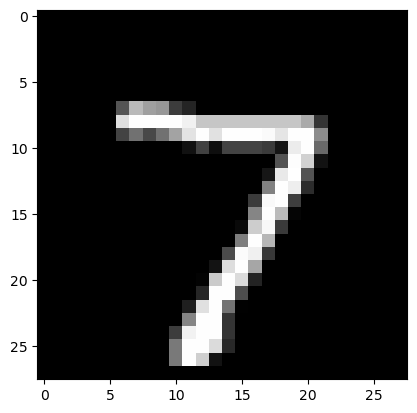

In [4]:
img = ds_test[0]

plt.imshow(img.reshape(28, 28), cmap='gray')

  0%|          | 0/5 [00:00<?, ?it/s]

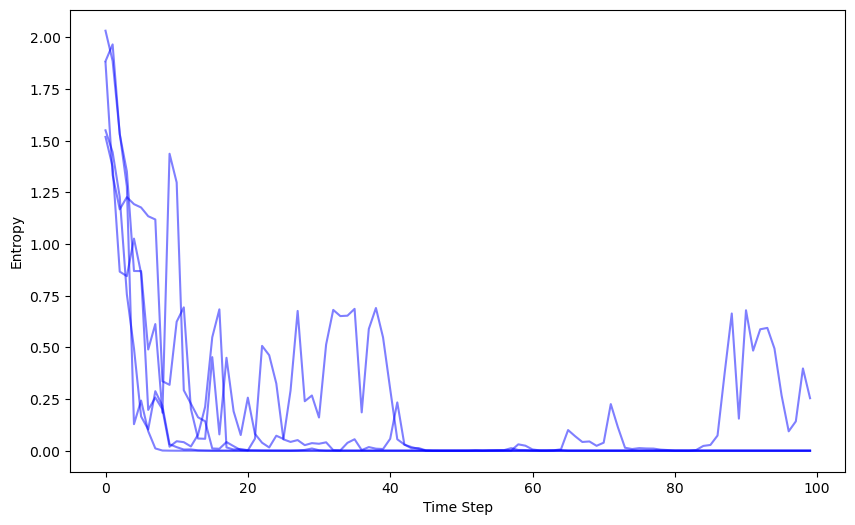

In [38]:

from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import entropy
import torch.nn as nn
from pssm.utils import cumulative_spike_matrix

threshold = .25
rts = []
fig, ax = plt.subplots(figsize=(10, 6))
for img in tqdm(ds_test[:5]):

    device = 'cpu'
    n_timesteps = 100
    encoder.eval().to(device)
    decoder.eval().to(device)

    dist, _, _, _ = encoder.forward(img.unsqueeze(0).unsqueeze(0).to(device))
    # encode the image into latent space
    # sample spikes train
    sample, indicator, times = dist.rsample(hard=True, return_indicator=True)
    # convert to cumulative spike matrix
    cumulative_matrix = cumulative_spike_matrix(indicator, times, n_steps=n_timesteps)

    #print("Cumulative matrix shape:", cumulative_matrix.shape)

    logits = [decoder(x.float().to(device)) for x in cumulative_matrix.T]
    probs = [nn.functional.softmax(logit, dim=-1) for logit in logits]
    entropies = [entropy(prob.detach().cpu().numpy()) for prob in probs]

    rts.append(np.where(np.array(entropies) < threshold)[0][0].item())


    ax.plot(torch.arange(100), entropies, label='Entropy', color='blue', alpha=0.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('Entropy')

plt.show()


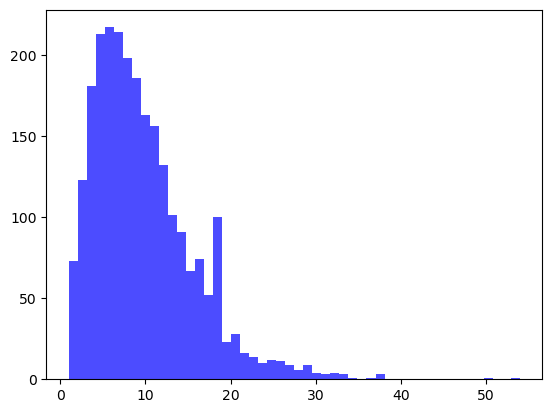

In [37]:
#plot histogram of rts
plt.hist(rts, bins=50, color='blue', alpha=0.7)

plt.show()